# Obtains the correlation matrix and the logistic regression model with their respective coefficient graphs.

### Note: This was run on Colab, so files are probably not available in local directories

In [29]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

#This code gets the correlation matrix and the logistic regression model

In [ ]:
#!pip install geopandas

In [ ]:
#Importing the needed libraries
import pandas as pd
import numpy as np
import geopandas as gpd


import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics

from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Importing the dataframe with which are we actually gonna work

#A random Sample of 20% of the clean, complete dataset, with the columns of the categorical variables with numerical values and
#with the column of "DS_ORIG" where 1.0 = born, 2.0 = fetal, 3.0 = deceased. Shape = (1579068, 65)
#df = pd.read_csv("/content/drive/My Drive/DS4AProject/CleanDB_FULL_DsOrigin_RandomSample_NumCat.csv") 
df = pd.read_csv("CleanDB_FULL_DsOrigin_RandomSample_NumCat.csv") 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print("Dataframe size: ",df.shape)
df.head()

Dataframe size:  (1579068, 66)


,Unnamed: 0,Unnamed: 0.1,APGAR1,APGAR2,AREA,AREA_RESIDENCIA_HAB,ASIS_MED,CERT_EXPEDIDO_POR,CODOCUR,COD_DPTO,COD_INST,DEPTO_RESIDENCIA,EDAD_MADRE,EDAD_PADRE,ESTADO_CIVIL_M,FECHA_NAC_HIJO_VIVO,FILE_YEAR,GRU_ED1,IDFACTORRH,IDHEMOCLAS,IDPERTET,IDPUEBLOIN,MANERA_MUERTE,MOMENTO_MUERTE,NACIDO_VIVO,NIV_EDUCATIVO_M,NIV_EDUCATIVO_P,NOMBRE_ADM_SALUD,NOM_INST,NUMERO_EMBARAZOS,NUM_CONSUL,N_HIJOSM,N_HIJOSV,ORIGINAL_FILE,PAIS_RESIDENCIA,PARTO_ATENDIDO_POR,PESO,PROFESION_QUIEN_CERTIFICA,RESULTADO_EMB,SEG_SOCIAL,SEXO,SITIO_EVENTO,TALLA,TIEMPO_GESTACION,TIPO_ADM_SALUD,TIPO_EMBARAZO,TIPO_PARTO,ULT_GRADO_MADRE,ULT_GRADO_PADRE,ID_BIRTH,ID_RESID,ID_VIOL,DATE,DS_ORIG,CERT_EXP_POR_CAT,MANERA_MUERTE_CAT,MOMENTO_MUERTE_CAT,PARTO_ATENDIDO_POR_CAT,PROFESION_QUIEN_CERTIFICA_CAT,SEG_SOCIAL_CAT,SEXO_CAT,SITIO_EVENTO_CAT,TIEMPO_GESTACION_CAT,TIPO_PARTO_CAT,TIPO_EMBARAZO_CAT,NACIDO_VIVO_INV
0,0,0,9.0,10.0,1,1.0,9.0,9,NaN,76,NaN,76,3.0,24.0,1.0,10/05/2014,2018,NaN,1.0,3.0,9.0,5.0,SIN_INFORMACION,SIN_INFORMACION,1,SECUNDARIA,SIN_INFORMACION,NaN,NaN,2.0,5.0,0.0,2.0,../Data/newData/nac/nac2018.txt,170.0,MEDICO,5.0,MEDICO,NACIDO_VIVO,SUBSIDIADO,FEMENINO,INSTITUCION_SALUD,5.0,38-41,2.0,SIMPLE,ESPONTANEO,9,99.0,76001,76001,1999,2018-07-01,1.0,9,9,9,1,1,3,1,1,4,1,1,0
1,1,1,8.0,9.0,1,1.0,9.0,9,NaN,8,8.00104e+10,8,2.0,19.0,1.0,NaN,2016,NaN,1.0,3.0,9.0,6.0,SIN_INFORMACION,SIN_INFORMACION,1,SECUNDARIA,SECUNDARIA,COOSALUD E.S.S. - ARS COOPERATIVA EMPRESA SOL...,IPS UNIVERSITARIA SEDE CAMINO EL BOSQUE DE MARIA,1.0,4.0,0.0,1.0,../Data/newData/nac/nac2016.txt,170.0,MEDICO,7.0,MEDICO,NACIDO_VIVO,SUBSIDIADO,FEMENINO,INSTITUCION_SALUD,5.0,38-41,2.0,SIMPLE,ESPONTANEO,10,11.0,8001,8001,1999,2016-07-01,1.0,9,9,9,1,1,3,1,1,4,1,1,0
2,2,2,8.0,9.0,1,1.0,9.0,9,NaN,8,8.758e+10,8,2.0,22.0,2.0,1900-01-01,2014,NaN,1.0,2.0,9.0,6.0,SIN_INFORMACION,SIN_INFORMACION,1,SECUNDARIA,SECUNDARIA,COMFACOR - CAJA DE COMPENSACION FAMILIAR DE CO...,CLINICA PORVENIR,1.0,5.0,0.0,1.0,../Data/newData/nac/nac2014.txt,170.0,MEDICO,6.0,MEDICO,NACIDO_VIVO,SUBSIDIADO,MASCULINO,INSTITUCION_SALUD,5.0,38-41,2.0,SIMPLE,CESAREA,11,7.0,8758,8758,1999,2014-09-01,1.0,9,9,9,1,1,3,2,1,4,2,1,0
3,3,3,8.0,9.0,1,1.0,9.0,9,NaN,11,1.10011e+11,11,2.0,19.0,1.0,1900-01-01,2014,NaN,1.0,3.0,9.0,6.0,SIN_INFORMACION,SIN_INFORMACION,1,SECUNDARIA,SECUNDARIA,CRUZ BLANCA EPS S.A.,CLINICA DEL OCCIDENTE S.A.,1.0,10.0,0.0,1.0,../Data/newData/nac/nac2014.txt,170.0,MEDICO,6.0,MEDICO,NACIDO_VIVO,CONTRIBUTIVO,FEMENINO,INSTITUCION_SALUD,5.0,38-41,1.0,SIMPLE,ESPONTANEO,11,11.0,11001,11001,1999,2014-08-01,1.0,9,9,9,1,1,1,1,1,4,1,1,0
4,4,4,9.0,9.0,1,1.0,9.0,9,NaN,47,4.7189e+11,47,2.0,21.0,2.0,2006-06-06,2009,NaN,1.0,4.0,9.0,6.0,SIN_INFORMACION,SIN_INFORMACION,1,SECUNDARIA,SECUNDARIA,NaN,HOSPITAL SAN CRISTOBAL,2.0,3.0,0.0,2.0,../Data/newData/nac/nac2009.txt,170.0,MEDICO,7.0,ENFERMERA,NACIDO_VIVO,NO_ASEGURADO,FEMENINO,INSTITUCION_SALUD,5.0,38-41,9.0,SIMPLE,ESPONTANEO,6,11.0,47189,47189,1999,2009-03-01,1.0,9,9,9,1,2,2,1,1,4,1,1,0


In [ ]:
#Getting the percentage of each category in the dataframe (live births, fetal deaths, deaths) 

print("Percentage of live births in the df",(df[df["DS_ORIG"] == 1].shape[0]/df.shape[0])*100)
print("Percentage of fetal deaths in the df",(df[df["DS_ORIG"] == 2].shape[0]/df.shape[0])*100)
print("Percentage of deaths in the df",(df[df["DS_ORIG"] == 3].shape[0]/df.shape[0])*100)

Percentage of live births in the df 93.10903646961373
Percentage of fetal deaths in the df 5.760423236998027
Percentage of deaths in the df 1.1305402933882518


#Correlation matrix

                          NUMBER OF PREGNANCIES  ...      SIZE
NUMBER OF PREGNANCIES                  1.000000  ...  0.280479
N. MEDICAL CONSULTATIONS               0.287301  ...  0.815134
MOTHER AGE                             0.329918  ...  0.105460
FATHER AGE                             0.291065  ...  0.851595
N. FEMALE CHILDREN                     0.717851  ...  0.227176
N. MALE CHILDREN                       0.735193  ...  0.181812
WEIGHT                                -0.006956  ... -0.018372
SIZE                                   0.280479  ...  1.000000

[8 rows x 8 columns]


Text(0.5, 1.0, 'Correlations between continuous variables')

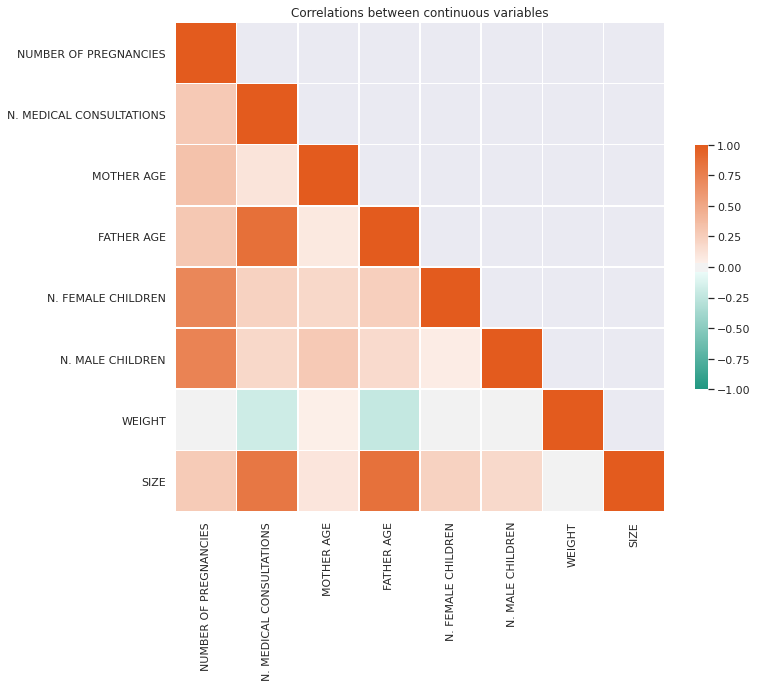

In [ ]:
data_full_E = [ df["NUMERO_EMBARAZOS"].astype(float), df["NUM_CONSUL"].astype(float),df['EDAD_MADRE'].astype(float),
        df['EDAD_PADRE'].astype(float),
         df['N_HIJOSM'].astype(float),df["N_HIJOSV"].astype(float),df['PESO'].astype(float),
        df["TALLA"].astype(float)]

headers_full_E = ["NUMBER OF PREGNANCIES","N. MEDICAL CONSULTATIONS",'MOTHER AGE','FATHER AGE','N. FEMALE CHILDREN',"N. MALE CHILDREN",'WEIGHT',"SIZE"]
df3_full_E = pd.concat(data_full_E, axis=1, keys=headers_full_E)
print(df3_full_E.corr(method="pearson")) 


mask = np.zeros_like(df3_full_E.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True    # Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False    # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))    # Generate a custom diverging colormap
cmap = sns.diverging_palette(168,22,s=94,l=56, as_cmap=True)    # Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(df3_full_E.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlations between continuous variables")


#Splitting the dataframe to solve the problem of live births vs. stillbirths

In [ ]:
#Getting the dataframe from the live births and fetal deaths only 

df_v = df[df["DS_ORIG"]==1]
df_f = df[df["DS_ORIG"]==2]
df_v_f = pd.concat([df_v,df_f])
df_v_f.shape

(1561216, 66)

In [ ]:
#Getting percentage of these categories to ensure representation of both categories

print("Percentage of live births in the df_v_f",(df_v_f[df_v_f["DS_ORIG"] == 1].shape[0]/df_v_f.shape[0])*100)
print("Percentage of fetal deaths in the df_v_f",(df_v_f[df_v_f["DS_ORIG"] == 2].shape[0]/df_v_f.shape[0])*100)

Percentage of live births in the df_v_f 94.17370818643928
Percentage of fetal deaths in the df_v_f 5.826291813560712


#Getting the random samples for train and test

In [ ]:
#Getting the random samples for train and test

df_v_f_train, df_v_f_test = train_test_split(df_v_f, train_size=0.8, shuffle = True, random_state=40)
print("Dataframe train shape: ",df_v_f_train.shape)
print("Dataframe test shape: ",df_v_f_test.shape)

Dataframe train shape:  (1248972, 66)
Dataframe test shape:  (312244, 66)


In [ ]:
#Adding a column to categorize by numbers the column "NIV_EDUCATIVO_M"

print(df_v_f_train["NIV_EDUCATIVO_M"].unique())
NIV_EDUCATIVO_M_dict = {
    "SIN_INFORMACION" : 9, "PREESCOLAR":1 , "PRIMARIA":2 ,
    "SECUNDARIA": 3 ,"PROFESIONAL":4, "MEDIA_TECNICA" : 5,"NORMALISTA":6,"TECNICA_PROFESIONAL":7, "TECNOLOGICA":8,"ESPECIALIZACION":10,"Maestría":10,"Doctorado":10}
df_v_f_train = df_v_f_train[df_v_f_train['NIV_EDUCATIVO_M'].isin(NIV_EDUCATIVO_M_dict.keys())].copy()
df_v_f_train['NIV_EDUCATIVO_M_CAT'] = df_v_f_train['NIV_EDUCATIVO_M'].apply(lambda x: NIV_EDUCATIVO_M_dict[x])
print(df_v_f_train['NIV_EDUCATIVO_M_CAT'].unique()) 
print(df_v_f_train.shape)

#df_v_f_train.head()

['SECUNDARIA' 'PROFESIONAL' 'SIN_INFORMACION' 'TECNICA_PROFESIONAL'
 'PRIMARIA' 'ESPECIALIZACION' 'MEDIA_TECNICA' 'TECNOLOGICA' 'NINGUNO'
 'PREESCOLAR' 'MAESTRIA' 'NORMALISTA' 'DOCTORADO']
[ 3  4  9  7  2 10  5  8  1  6]
(1231124, 67)


#Defining a new dataframe with the specific kind of variables (category, float) from each category


In [ ]:
dataToTrainLog= [
         df_v_f_train["DEPTO_RESIDENCIA"].astype('category')
        ,df_v_f_train["NUMERO_EMBARAZOS"].astype(float),df_v_f_train["NUM_CONSUL"].astype(float),df_v_f_train["N_HIJOSM"].astype(float),
        df_v_f_train["N_HIJOSV"].astype(float),df_v_f_train["TIPO_ADM_SALUD"].astype(float),df_v_f_train["SEXO_CAT"].astype('category'),df_v_f_train["NACIDO_VIVO_INV"].astype('category'), 
        df_v_f_train["CERT_EXP_POR_CAT"].astype('category'),df_v_f_train["MANERA_MUERTE_CAT"].astype('category'),df_v_f_train["MOMENTO_MUERTE_CAT"].astype('category'),
        df_v_f_train["PARTO_ATENDIDO_POR_CAT"].astype('category'), df_v_f_train["PROFESION_QUIEN_CERTIFICA_CAT"].astype('category'), 
        df_v_f_train["SEG_SOCIAL_CAT"].astype('category'),df_v_f_train["SITIO_EVENTO_CAT"].astype('category'),df_v_f_train["TIEMPO_GESTACION_CAT"].astype('category')
        ,df_v_f_train["TIPO_PARTO_CAT"].astype('category'),df_v_f_train["TIPO_EMBARAZO_CAT"].astype('category'),df_v_f_train["NIV_EDUCATIVO_M_CAT"].astype('category'),
        df_v_f_train["AREA_RESIDENCIA_HAB"].astype('category'),df_v_f_train["AREA"].astype('category'),df_v_f_train["ASIS_MED"].astype('category')]

headersToTrainLog= ["DEPTO_RESIDENCIA"
           ,"NUMERO_EMBARAZOS","NUM_CONSUL","N_HIJOSM","N_HIJOSV","TIPO_ADM_SALUD","SEXO_CAT","NACIDO_VIVO_INV","CERT_EXP_POR_CAT", "MANERA_MUERTE_CAT",
           "MOMENTO_MUERTE_CAT", "PARTO_ATENDIDO_POR_CAT","PROFESION_QUIEN_CERTIFICA_CAT","SEG_SOCIAL_CAT","SITIO_EVENTO_CAT","TIEMPO_GESTACION_CAT","TIPO_PARTO_CAT" ,
           "TIPO_EMBARAZO_CAT","NIV_EDUCATIVO_M_CAT","AREA_RESIDENCIA_HAB_CAT","AREA_CAT","ASIS_MED_CAT"]
dfToTrainLog= pd.concat(dataToTrainLog, axis=1, keys=headersToTrainLog)
print(dfToTrainLog.shape)
dfToTrainLog.head()


(1231124, 22)


,DEPTO_RESIDENCIA,NUMERO_EMBARAZOS,NUM_CONSUL,N_HIJOSM,N_HIJOSV,TIPO_ADM_SALUD,SEXO_CAT,NACIDO_VIVO_INV,CERT_EXP_POR_CAT,MANERA_MUERTE_CAT,MOMENTO_MUERTE_CAT,PARTO_ATENDIDO_POR_CAT,PROFESION_QUIEN_CERTIFICA_CAT,SEG_SOCIAL_CAT,SITIO_EVENTO_CAT,TIEMPO_GESTACION_CAT,TIPO_PARTO_CAT,TIPO_EMBARAZO_CAT,NIV_EDUCATIVO_M_CAT,AREA_RESIDENCIA_HAB_CAT,AREA_CAT,ASIS_MED_CAT
1517086,19,1.0,5.0,0.0,1.0,2.0,1,0,9,9,9,1,1,3,1,3,2,1,3,2.0,1,9.0
631514,54,1.0,4.0,0.0,1.0,1.0,2,0,9,9,9,1,1,1,1,3,2,1,4,1.0,1,9.0
230465,76,1.0,99.0,0.0,1.0,1.0,1,0,9,9,9,1,1,1,1,4,2,1,3,1.0,1,9.0
1126177,44,4.0,2.0,0.0,4.0,9.0,1,0,9,9,9,1,1,2,1,4,1,1,9,1.0,1,9.0
1544506,11,1.0,6.0,0.0,1.0,1.0,2,0,9,9,9,1,1,1,1,3,1,1,3,1.0,1,9.0


In [ ]:
#Defining a new data frame with the features that can be applied to the model

df_log1 = pd.DataFrame(columns=['NACIDO_VIVO_INV','NUMERO_EMBARAZOS','SEXO_CAT','SEG_SOCIAL_CAT',
                                'TIEMPO_GESTACION_CAT','NIV_EDUCATIVO_M_CAT','TIPO_EMBARAZO_CAT',
                                'AREA_RESIDENCIA_HAB_CAT','AREA_CAT','ASIS_MED_CAT','DEPTO_RESIDENCIA'])
df_log1['NACIDO_VIVO_INV'] = dfToTrainLog.NACIDO_VIVO_INV
df_log1['NUMERO_EMBARAZOS'] = dfToTrainLog.NUMERO_EMBARAZOS
df_log1['SEXO_CAT'] = dfToTrainLog.SEXO_CAT
df_log1['SEG_SOCIAL_CAT'] = dfToTrainLog.SEG_SOCIAL_CAT
df_log1['TIEMPO_GESTACION_CAT'] = dfToTrainLog.TIEMPO_GESTACION_CAT
df_log1['NIV_EDUCATIVO_M_CAT'] = dfToTrainLog.NIV_EDUCATIVO_M_CAT
df_log1['TIPO_EMBARAZO_CAT'] = dfToTrainLog.TIPO_EMBARAZO_CAT
df_log1['AREA_RESIDENCIA_HAB_CAT'] = dfToTrainLog.AREA_RESIDENCIA_HAB_CAT
df_log1['AREA_CAT'] = dfToTrainLog.AREA_CAT
df_log1['ASIS_MED_CAT'] = dfToTrainLog.ASIS_MED_CAT
df_log1['DEPTO_RESIDENCIA'] = dfToTrainLog.DEPTO_RESIDENCIA
df_log1['Intercept'] = 1

#The following dataframe is used for training the random forest.
 It is stored not to carry out the procedure again

In [ ]:
df_dummies2 = pd.get_dummies(df_log1, columns=['SEG_SOCIAL_CAT','NIV_EDUCATIVO_M_CAT','TIPO_EMBARAZO_CAT',
                                               'AREA_RESIDENCIA_HAB_CAT','DEPTO_RESIDENCIA'], drop_first= True)
columnasInterDepto = list(df_dummies2.columns.drop(['NACIDO_VIVO_INV','SEXO_CAT','TIEMPO_GESTACION_CAT','ASIS_MED_CAT','AREA_CAT']))

In [ ]:
#df_dummies2.to_csv("DataRegresionDummies.csv")

#Logistic regression

In [ ]:
df_dummiesDeptos2 = pd.get_dummies(df_log1, columns=['SEG_SOCIAL_CAT','NIV_EDUCATIVO_M_CAT','TIPO_EMBARAZO_CAT',
                                               'AREA_RESIDENCIA_HAB_CAT','DEPTO_RESIDENCIA'], drop_first= False)
columnasInterDeptos2 = list(df_dummiesDeptos2.columns.drop(['NACIDO_VIVO_INV','SEXO_CAT','TIEMPO_GESTACION_CAT','ASIS_MED_CAT','AREA_CAT',
                                                            'SEG_SOCIAL_CAT_1','NIV_EDUCATIVO_M_CAT_1','TIPO_EMBARAZO_CAT_1','AREA_RESIDENCIA_HAB_CAT_1.0','DEPTO_RESIDENCIA_11']))

The following coefficients are based on the following category: Social Security = contributory, Niv_educative_m = Preschool, Type_pregnancy = Simple, Area_residency = Municipal Head, Depto_residencia = Bogota

In [ ]:
logitDeptos2 = sm.Logit(df_dummiesDeptos2['NACIDO_VIVO_INV'], df_dummiesDeptos2[columnasInterDeptos2])
logit_res_Deptos2 = logitDeptos2.fit()
logit_res_Deptos2.summary()

Optimization terminated successfully.
         Current function value: 0.177384
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        NACIDO_VIVO_INV   No. Observations:              1231124
Model:                          Logit   Df Residuals:                  1231067
Method:                           MLE   Df Model:                           56
Date:                Sun, 02 Aug 2020   Pseudo R-squ.:                  0.2052
Time:                        23:12:44   Log-Likelihood:            -2.1838e+05
converged:                       True   LL-Null:                   -2.7475e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
NUMERO_EMBARAZOS                0.0368      0.000    132.197      0.000       0.036       0.037
Intercept                      -2.6547      0.083    -31.989      0.000      -2.817      -2.492
SEG_SOCIAL_CAT_2                0.4082      0.016     25.842      0.000       0.377       0.439
SEG_SOCIAL_CAT_3               -0.0640      0.011     -5.911      0.000      -0.085      -0.043
SEG_SOCIAL_CAT_4               -0.0954      0.029     -3.247      0.001      -0.153      -0.038
SEG_SOCIAL_CAT_5               -0.3288      0.149     -2.205      0.027      -0.621      -0.037
SEG_SOCIAL_CAT_9               -2.4961      0.085    -29.389      0.000      -2.663      -2.330
NIV_EDUCATIVO_M_CAT_2          -0.3141      0.083     -3.788      0.000      -0.477      -0.152
NIV_EDUCATIVO_M_CAT_3          -0.1777      0.082     -2.157      0.031      -0.339      -0.016
NIV_EDUCATIVO_M_CAT_4          -0.2863      0.084     -3.422      0.001      -0.450      -0.122
NIV_EDUCATIVO_M_CAT_5          -0.0305      0.088     -0.347      0.728      -0.203       0.142
NIV_EDUCATIVO_M_CAT_6           0.7667      0.117      6.552      0.000       0.537       0.996
NIV_EDUCATIVO_M_CAT_7          -0.3987      0.085     -4.705      0.000      -0.565      -0.233
NIV_EDUCATIVO_M_CAT_8          -0.5281      0.087     -6.091      0.000      -0.698      -0.358
NIV_EDUCATIVO_M_CAT_9           1.1522      0.084     13.790      0.000       0.988       1.316
NIV_EDUCATIVO_M_CAT_10         -0.6388      0.100     -6.408      0.000      -0.834      -0.443
TIPO_EMBARAZO_CAT_2             0.3644      0.030     12.338      0.000       0.306       0.422
TIPO_EMBARAZO_CAT_3             1.2873      0.134      9.608      0.000       1.025       1.550
TIPO_EMBARAZO_CAT_4             1.7179      0.218      7.889      0.000       1.291       2.145
TIPO_EMBARAZO_CAT_9             4.3008      0.020    215.505      0.000       4.262       4.340
AREA_RESIDENCIA_HAB_CAT_2.0    -0.3741      0.020    -18.952      0.000      -0.413      -0.335
AREA_RESIDENCIA_HAB_CAT_3.0    -0.4197      0.015    -27.453      0.000      -0.450      -0.390
AREA_RESIDENCIA_HAB_CAT_9.0    -1.9593      0.086    -22.746      0.000      -2.128      -1.790
DEPTO_RESIDENCIA_1              0.8275      0.160      5.159      0.000       0.513       1.142
DEPTO_RESIDENCIA_5             -0.1262      0.015     -8.283      0.000      -0.156      -0.096
DEPTO_RESIDENCIA_8             -1.6415      0.032    -50.831      0.000      -1.705      -1.578
DEPTO_RESIDENCIA_13            -1.2467      0.030    -41.692      0.000      -1.305      -1.188
DEPTO_RESIDENCIA_15            -0.8089      0.040    -20.382      0.000      -0.887      -0.731
DEPTO_RESIDENCIA_17            -0.2608      0.037     -7.005      0.000      -0.334      -0.188
DEPTO_RESIDENCIA_18            -0.8723      0.055    -15.896      0.000      -0.980      -0.765
DEPTO_RESIDENCIA_19            -0.2819      0.031     -9.074      0.000  

#ROC CURVE

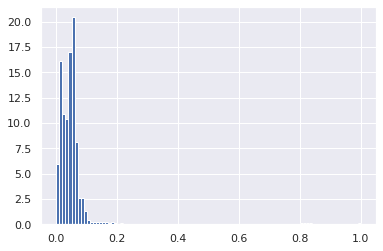

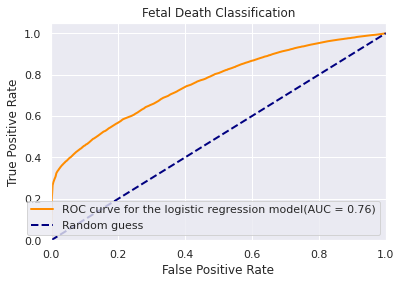

In [ ]:
#ROC Curves for the logistic regression 

pscoreLogitDummies = logit_res_Deptos2.predict()
plt.hist((pscoreLogitDummies),density=True, bins = 100);


roc_p = metrics.roc_curve(df_dummiesDeptos2['NACIDO_VIVO_INV'], pscoreLogitDummies)
auc_p = metrics.auc( roc_p[0], roc_p[1] )
plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for the logistic regression model(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fetal Death Classification')
plt.legend(loc='lower right')
plt.show()

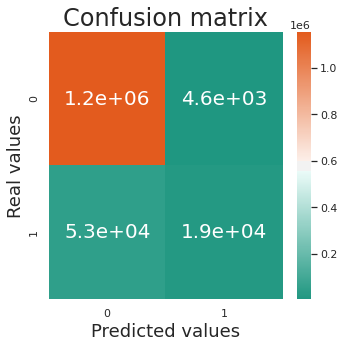

In [ ]:
#Confussion Matrix 
cm = logit_res_Deptos2.pred_table(threshold=0.5)
plt.figure(figsize=(5,5))
cmap = sns.diverging_palette(168,22,s=94,l=56, as_cmap=True)    # Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cm, cmap = cmap, annot=True,annot_kws={"size": 20})
# labels, title and ticks
plt.xlabel('Predicted values',fontsize=18)
plt.ylabel('Real values',fontsize=18)
plt.title('Confusion matrix',fontsize=24)
plt.tight_layout()

#Graphing the coefficients obtained in the logistic regression

In [ ]:
#Getting the coefficients from the model
coeffs = logit_res_Deptos2.params
coeffs.head

<bound method NDFrame.head of NUMERO_EMBARAZOS               0.036759
Intercept                     -2.654684
SEG_SOCIAL_CAT_2               0.408191
SEG_SOCIAL_CAT_3              -0.063989
SEG_SOCIAL_CAT_4              -0.095403
SEG_SOCIAL_CAT_5              -0.328794
SEG_SOCIAL_CAT_9              -2.496089
NIV_EDUCATIVO_M_CAT_2         -0.314089
NIV_EDUCATIVO_M_CAT_3         -0.177745
NIV_EDUCATIVO_M_CAT_4         -0.286268
NIV_EDUCATIVO_M_CAT_5         -0.030505
NIV_EDUCATIVO_M_CAT_6          0.766688
NIV_EDUCATIVO_M_CAT_7         -0.398750
NIV_EDUCATIVO_M_CAT_8         -0.528104
NIV_EDUCATIVO_M_CAT_9          1.152241
NIV_EDUCATIVO_M_CAT_10        -0.638836
TIPO_EMBARAZO_CAT_2            0.364356
TIPO_EMBARAZO_CAT_3            1.287274
TIPO_EMBARAZO_CAT_4            1.717879
TIPO_EMBARAZO_CAT_9            4.300801
AREA_RESIDENCIA_HAB_CAT_2.0   -0.374051
AREA_RESIDENCIA_HAB_CAT_3.0   -0.419718
AREA_RESIDENCIA_HAB_CAT_9.0   -1.959283
DEPTO_RESIDENCIA_1             0.827520
DEPTO_RESI

In [ ]:
seg_soc = coeffs[coeffs.index.str.startswith('SEG_SOC')].copy()
seg_soc.index = seg_soc.index.str[-1].astype(int)
seg_soc.sort_index(inplace=True)
seg_soc.name = "0"
seg_soc

2    0.408191
3   -0.063989
4   -0.095403
5   -0.328794
9   -2.496089
Name: 0, dtype: float64

In [ ]:
tipo_emb = coeffs[coeffs.index.str.startswith('TIPO_EMB')].copy()
tipo_emb.index = tipo_emb.index.str[-1].astype(int)
tipo_emb.sort_index(inplace=True)

In [ ]:
niv_edu = coeffs[coeffs.index.str.startswith('NIV_EDU')].copy()
niv_edu.index = niv_edu.index.str[-1:].astype(int)
niv_edu.loc[10] = niv_edu.loc[0]
niv_edu=niv_edu.drop(0)
niv_edu.sort_index(inplace=True)
niv_edu.name = "0"
niv_edu

2    -0.314089
3    -0.177745
4    -0.286268
5    -0.030505
6     0.766688
7    -0.398750
8    -0.528104
9     1.152241
10   -0.638836
Name: 0, dtype: float64

In [ ]:
area_res = coeffs[coeffs.index.str.startswith('AREA')].copy()
area_res.index = area_res.index.str[-3:].astype(float)
area_res.name = "0"
area_res

2.0   -0.374051
3.0   -0.419718
9.0   -1.959283
Name: 0, dtype: float64

In [ ]:
dpto = coeffs[coeffs.index.str.startswith('DEPTO')].copy()
dpto.name = "0"
dpto.index = dpto.index.str[-2:].str.replace('_','0')
dpto.loc['11'] = 0
dpto

01    0.827520
05   -0.126194
08   -1.641525
13   -1.246678
15   -0.808883
17   -0.260805
18   -0.872283
19   -0.281882
20   -1.872055
23    0.010094
25    0.062801
27   -1.531352
41    0.521446
44   -2.151642
47   -1.120390
50    0.215271
52    0.172581
54   -0.730449
63    0.047606
66    0.028183
68   -0.933967
70   -0.417809
73    0.001633
75    1.841323
76   -0.229723
81    0.309571
85   -1.449363
86    0.084112
88    0.929280
91   -1.628608
94   -0.409682
95   -0.596161
97   -1.844854
99   -1.045282
11    0.000000
Name: 0, dtype: float64

In [ ]:
geo_df = gpd.read_file("/content/drive/My Drive/DS4AProject/GeoData/MGN_DPTO_POLITICO.shp")
geo_df = geo_df.merge(dpto,left_on='DPTO_CCDGO',right_index=True).rename(columns={'0':'LogitCoeff'})
#geo_df.LogitCoeff -= geo_df.LogitCoeff.min()  #Rescale so minimum is at 0
geo_df.head()

,DPTO_CCDGO,DPTO_CNMBR,DPTO_NANO_,DPTO_CACTO,DPTO_NANO,Shape_Leng,Shape_Area,geometry,LogitCoeff
0,18,CAQUETÁ,1981,Ley 78 del 29 de Diciembre de 1981,2018,21.384287,7.318485,"POLYGON ((-74.89423 2.95852, -74.89410 2.95852...",-0.872283
1,19,CAUCA,1857,15 de junio de 1857,2018,13.950263,2.534419,"POLYGON ((-76.45922 3.32872, -76.45878 3.32870...",-0.281882
2,86,PUTUMAYO,1991,Articulo 309 Constitucion Politica de 1991,2018,12.707922,2.107965,"POLYGON ((-76.67050 1.46732, -76.67000 1.46730...",0.084112
3,76,VALLE DEL CAUCA,1910,Decreto No 340 de 16 de Abril de 1910,2018,12.650870,1.679487,"MULTIPOLYGON (((-77.23810 4.04049, -77.23774 4...",-0.229723
4,94,GUAINÍA,1991,Articulo 309 Constitucion Politica de 1991,2018,21.179051,5.747937,"POLYGON ((-67.67638 3.91228, -67.67305 3.90931...",-0.409682


In [ ]:
#from matplotlib.colors import LinearSegmentedColormap
colors = [
       [0.        , 0.62745098, 0.50588235],
       [0.92941176, 0.93333333, 0.9372549 ],
       [0.01568627, 0.30196078, 0.43137255]]

cm = LinearSegmentedColormap.from_list(
    'custom', colors, N=100)

cm

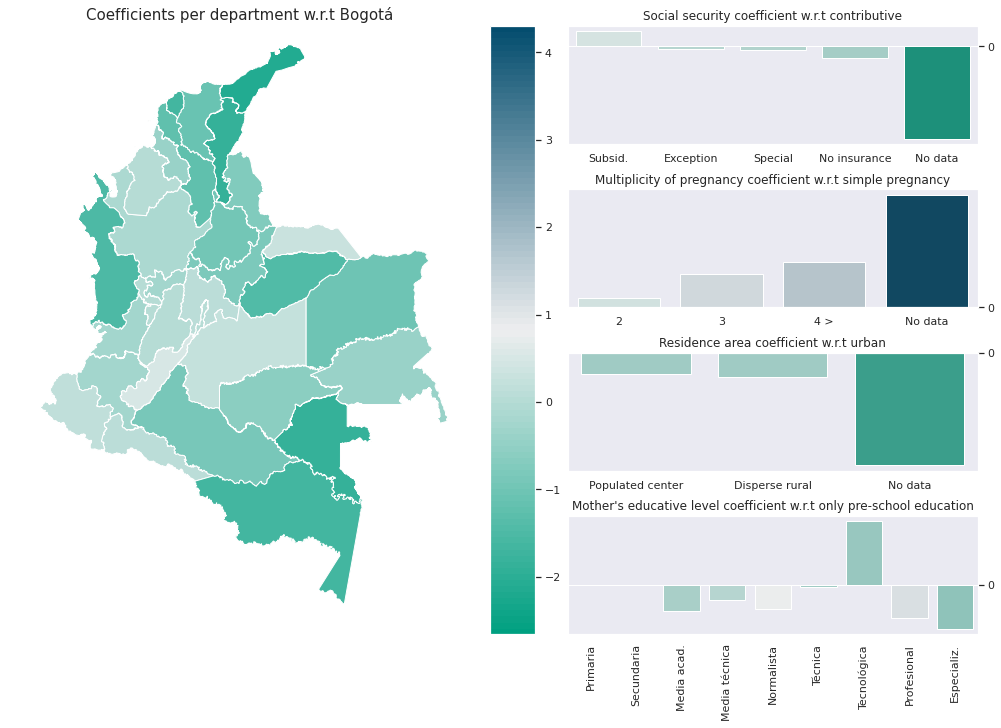

In [ ]:
fig = plt.figure(figsize=(15,10),constrained_layout=True)

gs = GridSpec(4, 40, figure=fig)
len_side = 17  #Relative size of the plots on the right

ax1 = fig.add_subplot(gs[:, :-len_side])
ax2 = fig.add_subplot(gs[0, -len_side:])
ax3 = fig.add_subplot(gs[1, -len_side:])
ax4 = fig.add_subplot(gs[2, -len_side:])
ax5 = fig.add_subplot(gs[3, -len_side:])

my_cmap = cm 

vmin,vmax = coeffs.min(),coeffs.max()
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin,vmax))
sm.set_array([])

#Map
geo_df.plot('LogitCoeff',ax=ax1,legend=True,cmap=my_cmap,vmin=vmin,vmax=vmax)
ax1.set_xlim(left=-80)
ax1.set_ylim(top=13)
ax1.axis('off')
ax1.set_title('Coefficients per department w.r.t Bogotá',fontsize=15)

#Seguridad social
clrs = sm.to_rgba(seg_soc.values)
sns.barplot(data=seg_soc.reset_index(),x='index',y=seg_soc.values,
            ax=ax2,palette=clrs)
ax2.set_title('Social security coefficient w.r.t contributive')
ax2.set_xticklabels(['Subsid.','Exception','Special','No insurance','No data'])

#Tipo emb
clrs = sm.to_rgba(tipo_emb.values)
sns.barplot(data=tipo_emb.reset_index(),x='index',y=tipo_emb.values,
            ax=ax3,palette=clrs)
ax3.set_title('Multiplicity of pregnancy coefficient w.r.t simple pregnancy')
ax3.set_xticklabels(['2','3','4 >','No data'])


#Area residencia
clrs = sm.to_rgba(area_res.values)
sns.barplot(data=area_res.reset_index(),x='index',y=area_res.values,
            ax=ax4,palette=clrs)
ax4.set_title('Residence area coefficient w.r.t urban')
ax4.set_xticklabels(['Populated center','Disperse rural','No data'])

#Nivel educ
clrs = sm.to_rgba(niv_edu.values)
sns.barplot(data=niv_edu.reset_index(),x='index',y=niv_edu,
            ax=ax5,palette=clrs)    
ax5.set_title('Mother\'s educative level coefficient w.r.t only pre-school education')
ax5.set_xticklabels(['Primaria','Secundaria','Media acad.','Media técnica','Normalista',
                     'Técnica','Tecnológica','Profesional','Especializ.','Otros'],rotation=90)

for ax in [ax1,ax2,ax3,ax4,ax5]:
    #Set yticks on the right
    ax.set_yticks([0])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel('')
    ax.set_xlabel('')

#plt.savefig('../Plots/LogitCoeffs.png',dpi=300,bbox_inches='tight')
#plt.show()